# Comparação entre o modelo MTL com o uso de embeddings HGI e HMMR


**Configurações usadas**

### **InputsConfig**  
- **EMBEDDING_DIM**: 64  
- **SLIDE_WINDOW**: 9  
- **PAD_VALUE**: 0  
- **TIMEOUT_TEST**: None  
- **NEXT_TARGET**: None  
- **CATEGORY_TARGET**: None  

---

### **MTLModelConfig**  
- **NUM_CLASSES**: 7  
- **BATCH_SIZE**: 2048  
- **EPOCHS**: 50  
- **LEARNING_RATE**: 0.0001  
- **K_FOLDS**: 3  

---

### **ModelParameters**  
- **INPUT_DIM**: 64
- **SHARED_LAYER_SIZE**: 256  
- **NUM_HEADS**: 8  
- **NUM_LAYERS**: 4  
- **SEQ_LENGTH**: 9  
- **NUM_SHARED_LAYERS**: 4  
- **ENCODER_OUTPUT_SIZE**: 256  
- **EXPERT_HIDDEN_SIZE**: 256  
- **EXPERT_OUTPUT_SIZE**: 256  
- **NUM_EXPERTS**: 9  


# Montana

In [ ]:
ESTADO = "montana"

## HGI

In [ ]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
diretorio_principal = "/content/drive/MyDrive/MTL_POI_Novo"

In [ ]:
%cd {diretorio_principal}/PoiMtlNet

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet


In [ ]:
import os
os.environ["DATA_ROOT"] = f"{diretorio_principal}/data"
os.environ["RESULTS_ROOT"] = f"{diretorio_principal}/results"



In [ ]:
!pip install numpy

In [ ]:
from configs.paths import DATA_ROOT, RESULTS_ROOT, IO_CHECKINS, OUTPUT_ROOT, TEMP_DIR
print("DATA_ROOT =", DATA_ROOT)
print("RESULTS_ROOT =", RESULTS_ROOT)
print("IO_CHECKINS =", IO_CHECKINS)
print("OUTPUT_ROOT =", OUTPUT_ROOT)
print("TEMP_DIR =", TEMP_DIR)


DATA_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data
RESULTS_ROOT = /content/drive/MyDrive/MTL_POI_Novo/results
IO_CHECKINS = /content/drive/MyDrive/MTL_POI_Novo/data/checkins
OUTPUT_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data/output
TEMP_DIR = /content/drive/MyDrive/MTL_POI_Novo/data/temp


## Primeiro, passe o "poi_embedding.torch" da pasta data do HGI para a pasta "output/{state}" e execute o seguinte código para converter no formato csv apropriado

In [ ]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (chk.dropna(subset=["category"])
                      .groupby("placeid")["category"]
                      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True
):
    emb = load_tensor(path_torch)
    V, D = emb.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    col_names = [str(i) for i in range(D)]
    df = pd.DataFrame(emb, columns=col_names)
    df.insert(0, "placeid", placeids)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df["category"] = df["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df["category"] = np.nan
    else:
        df["category"] = np.nan

    df.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    return df


save_poi_torch_to_csv(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True
)


SyntaxError: f-string: expecting '}' (ipython-input-885546095.py, line 6)

## Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 200, Total visit sequences: 654
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 200/200 [00:00<00:00, 29576.93it/s]
nextpoi_sequences shape: (654, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/poi-sequences.csv

Generating next POI input data...
Resuming from row 654 (found existing file).
Batches: 0it [00:00, ?it/s]
Finished: wrote 654 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-06 12:36:40.877264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759754200.924851    8364 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759754200.938659    8364 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759754200.975348    8364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759754200.975407    8364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759754200.975417    8364 computation_placer.cc:177] computation placer alr

## Sumário do Treino

In [15]:
pasta_results = f"{diretorio_principal}/results/montana/mtlnet_lr1.0e-04_bs2048_ep50_20251006_1236"

### Category

In [16]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,64.08 ± 14.18,66.26 ± 8.50,64.53 ± 9.53,3266.67 ± 57.74
1,Entertainment,47.29 ± 18.12,19.37 ± 0.55,26.92 ± 3.10,2066.67 ± 57.74
2,Food,71.58 ± 3.02,76.38 ± 5.53,73.78 ± 2.55,13966.67 ± 57.74
3,Nightlife,57.85 ± 7.62,54.76 ± 5.46,55.84 ± 2.63,2800.00 ± 0.00
4,Outdoors,67.92 ± 9.16,69.19 ± 3.08,68.28 ± 4.81,3133.33 ± 57.74


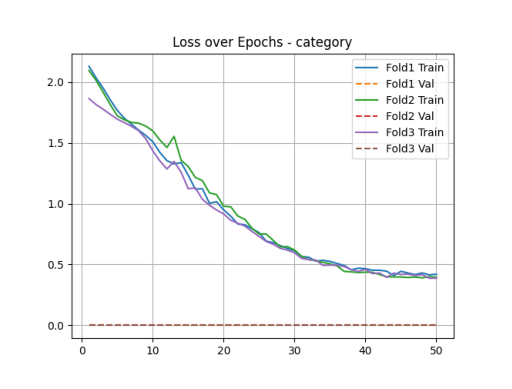

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Next

In [18]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,53.78 ± 2.75,75.65 ± 10.08,62.55 ± 2.40,4366.67 ± 57.74
1,Entertainment,18.84 ± 4.09,23.21 ± 9.28,20.62 ± 6.35,733.33 ± 57.74
2,Food,41.92 ± 8.34,12.22 ± 10.84,16.87 ± 13.45,6000.00 ± 0.00
3,Nightlife,34.44 ± 15.03,24.36 ± 8.41,26.27 ± 4.81,1233.33 ± 57.74
4,Outdoors,32.06 ± 7.78,54.03 ± 18.45,39.60 ± 9.67,1533.33 ± 57.74


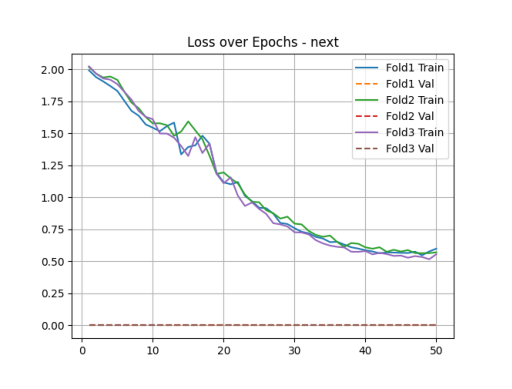

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Geral (Model)

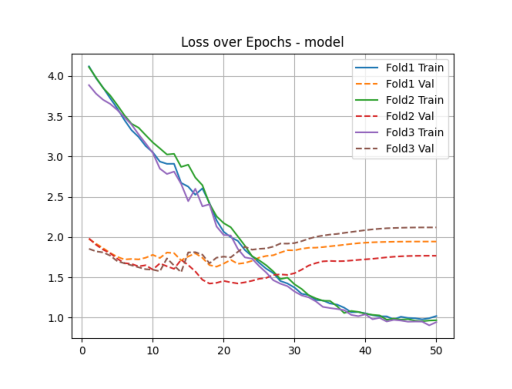

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

# California

In [2]:
ESTADO = "california"

## HGI

In [3]:
from google.colab import drive

drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [4]:
diretorio_principal = "/content/drive/MyDrive/MTL_POI_Novo"

In [5]:
%cd {diretorio_principal}/PoiMtlNet

/content/drive/MyDrive/MTL_POI_Novo/PoiMtlNet


In [6]:
import os
os.environ["DATA_ROOT"] = f"{diretorio_principal}/data"
os.environ["RESULTS_ROOT"] = f"{diretorio_principal}/results"



In [7]:
!pip install numpy

In [8]:
from configs.paths import DATA_ROOT, RESULTS_ROOT, IO_CHECKINS, OUTPUT_ROOT, TEMP_DIR
print("DATA_ROOT =", DATA_ROOT)
print("RESULTS_ROOT =", RESULTS_ROOT)
print("IO_CHECKINS =", IO_CHECKINS)
print("OUTPUT_ROOT =", OUTPUT_ROOT)
print("TEMP_DIR =", TEMP_DIR)


DATA_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data
RESULTS_ROOT = /content/drive/MyDrive/MTL_POI_Novo/results
IO_CHECKINS = /content/drive/MyDrive/MTL_POI_Novo/data/checkins
OUTPUT_ROOT = /content/drive/MyDrive/MTL_POI_Novo/data/output
TEMP_DIR = /content/drive/MyDrive/MTL_POI_Novo/data/temp


## Primeiro, passe o "poi_embedding.torch" da pasta data do HGI para a pasta "output/{state}" e execute o seguinte código para converter no formato csv apropriado

In [1]:
import os
import torch
import pandas as pd
import numpy as np

pasta_output = f"{diretorio_principal}/data/output/{ESTADO}/"
def load_tensor(path_torch):
    obj = torch.load(path_torch, map_location="cpu")
    if hasattr(obj, "detach"):
        obj = obj.detach()
    return obj.cpu().numpy()

def _placeids_from_pois_trim(pois_csv, V):
    pois = pd.read_csv(pois_csv)

    if "feature_id" not in pois.columns:
        raise KeyError("pois_csv precisa conter a coluna 'feature_id'.")

    pois = pois.drop_duplicates(subset=["feature_id"]).reset_index(drop=True)

    n_before = len(pois)
    if n_before > V:
        pois = pois.iloc[:V].copy()
        print(f"[INFO] Cortando extras: {n_before} -> {V} feature_id (removidos {n_before - V}).")
    elif n_before < V:
        print(f"[AVISO] POIs ({n_before}) < V ({V}). "
              f"Embeddings terão linhas sem ID correspondente (não recomendado).")

    placeids = pois["feature_id"].astype(str).tolist()
    return placeids

def _category_from_checkins(checkins_csv):
    chk = pd.read_csv(checkins_csv)
    if "placeid" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'placeid'.")
    if "category" not in chk.columns:
        raise KeyError("checkins_csv precisa conter a coluna 'category' (string).")

    chk["placeid"] = chk["placeid"].astype(str)

    cat_by_place = (chk.dropna(subset=["category"])
                      .groupby("placeid")["category"]
                      .agg(lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]))
    cat_by_place.index = cat_by_place.index.astype(str)
    return cat_by_place

def save_poi_torch_to_csv(
    path_torch,
    out_csv,
    pois_csv,
    checkins_csv,
    include_category=True
):
    emb = load_tensor(path_torch)
    V, D = emb.shape

    placeids = _placeids_from_pois_trim(pois_csv, V)

    col_names = [str(i) for i in range(D)]
    df = pd.DataFrame(emb, columns=col_names)
    df.insert(0, "placeid", placeids)

    if include_category:
        try:
            cat_by_place = _category_from_checkins(checkins_csv)
            cat_map = cat_by_place.to_dict()
            df["category"] = df["placeid"].map(cat_map)
        except Exception as e:
            print(f"[AVISO] Não foi possível carregar category de {checkins_csv}: {e}")
            df["category"] = np.nan
    else:
        df["category"] = np.nan

    df.to_csv(out_csv, index=False)
    print(f"Arquivo salvo em: {out_csv}")
    return df


save_poi_torch_to_csv(
    path_torch=f"{pasta_output}/poi_embedding.torch",
    out_csv=f"{pasta_output}/embeddings.csv",
    pois_csv=f"{pasta_output}/pois_gowalla.csv",
    checkins_csv=f"{pasta_output}/filtrado.csv",
    include_category=True
)


SyntaxError: f-string: expecting '}' (ipython-input-885546095.py, line 6)

## Treino com novo modelo de embeddings pelo HGI

In [ ]:
!python -m pipelines.create_inputs {ESTADO}

Generating sequences for each user...
Users with valid sequences: 200, Total visit sequences: 654
Preparing embeddings...
Generating sequences DataFrame...
Processing users: 100% 200/200 [00:00<00:00, 29576.93it/s]
nextpoi_sequences shape: (654, 11)
Success: nextpoi_sequences saved at /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/poi-sequences.csv

Generating next POI input data...
Resuming from row 654 (found existing file).
Batches: 0it [00:00, ?it/s]
Finished: wrote 654 sequences to /content/drive/MyDrive/MTL_POI_Novo/data/output/montana/pre-processing/next-input.csv
Processing complete!


In [ ]:
!python -m pipelines.mtlnet_trainer {ESTADO}

2025-10-06 12:36:40.877264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759754200.924851    8364 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759754200.938659    8364 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1759754200.975348    8364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759754200.975407    8364 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1759754200.975417    8364 computation_placer.cc:177] computation placer alr

## Sumário do Treino

In [9]:
pasta_results = f"{diretorio_principal}/results/california/mtlnet_lr1.0e-04_bs2048_ep50_20251017_2100"

### Category

In [10]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_category_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,53.39 ± 1.71,29.47 ± 0.57,37.97 ± 0.14,658100.00 ± 0.00
1,Entertainment,54.50 ± 7.16,25.17 ± 1.93,34.24 ± 0.79,227366.67 ± 57.74
2,Food,58.91 ± 1.23,54.35 ± 3.05,56.48 ± 1.13,1704033.33 ± 57.74
3,Nightlife,61.77 ± 4.38,33.87 ± 0.47,43.73 ± 1.44,168666.67 ± 57.74
4,Outdoors,55.49 ± 2.66,24.75 ± 0.76,34.21 ± 0.37,320100.00 ± 0.00


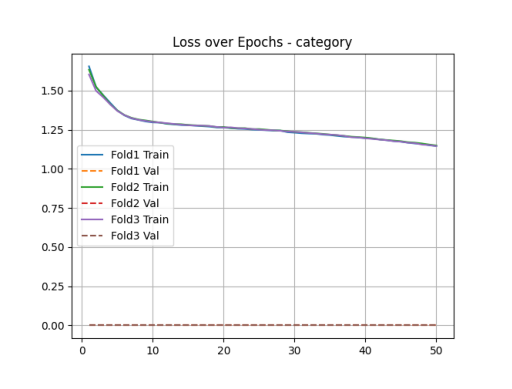

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/category/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Next

In [12]:
import pandas as pd

df = pd.read_csv(f"{pasta_results}/summary/summary_next_metrics_formatted.csv")
df.head()

,Category,precision,recall,f1-score,support
0,Community,33.14 ± 1.26,34.29 ± 2.87,33.62 ± 0.71,729366.67 ± 611.01
1,Entertainment,18.31 ± 1.07,24.17 ± 2.50,20.80 ± 1.27,343500.00 ± 984.89
2,Food,47.83 ± 0.81,21.54 ± 2.56,29.62 ± 2.23,1727600.00 ± 15062.20
3,Nightlife,15.17 ± 0.54,38.69 ± 1.77,21.77 ± 0.28,267033.33 ± 2285.46
4,Outdoors,18.69 ± 2.30,31.71 ± 4.49,23.32 ± 1.29,382000.00 ± 1646.21


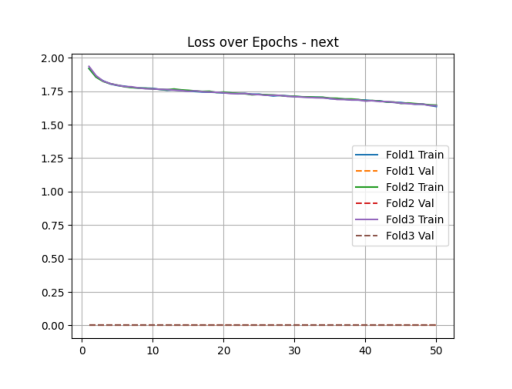

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/next/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()

### Geral (Model)

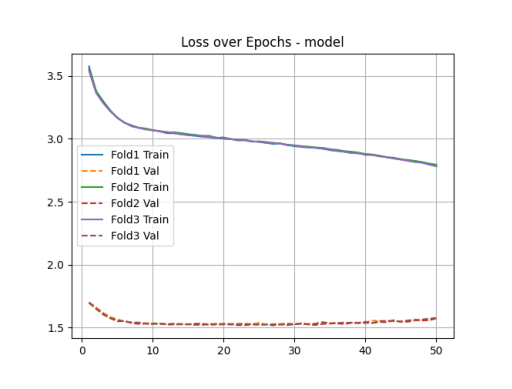

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img_path = f'{pasta_results}/plots/model/loss.png'

img = mpimg.imread(img_path)

plt.imshow(img)
plt.axis('off')
plt.show()